# Time Series Analysis & Recurrent Neural Networks
## Final Project
### Lars Kühmichel, Nicolas Wolf

The final project is about analyzing the dynamics of a time series of weather data from across Europe. The goal is to
- reconstruct the dynamics behind the data, especially the annual and daily rhythms
- predict the future of the time series
- and compare two model architectures with respect to the results.

In [350]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib as pl
import seaborn as sns
import statsmodels.api as sm

In [351]:
plt.rc("figure", dpi=200)
plt.rc("legend", fontsize=6)

We first run a modified version of the provided code to download the dataset and save it locally.

In [352]:
def running_mean(x, N):
    w = np.ones(N) / N
    if x.ndim > 1:
        res = []
        for i in range(x.shape[1]):
            res.append(np.convolve(w, x[:, i], 'valid'))
        return np.array(res).T
    else:
        return np.convolve(w, x, 'valid')

In [353]:
data_root = pl.Path("data")
data_root.mkdir(exist_ok=True, parents=True)

data_path = data_root / "weather_data.csv"

if not data_path.is_file():
    data_url = r"https://data.open-power-system-data.org/weather_data/2020-09-16/weather_data.csv"
    data = pd.read_csv(data_url)
    data.to_csv(data_path)
else:
    data = pd.read_csv(data_path)

The dataset contains hourly geographically aggregated weather (radiation and temperature) data for Europe. It covers the European countries using a population-weighted mean across all MERRA-2 grid cells within the given country.

In [354]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350640 entries, 0 to 350639
Data columns (total 86 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Unnamed: 0                       350640 non-null  int64  
 1   utc_timestamp                    350640 non-null  object 
 2   AT_temperature                   350640 non-null  float64
 3   AT_radiation_direct_horizontal   350640 non-null  float64
 4   AT_radiation_diffuse_horizontal  350640 non-null  float64
 5   BE_temperature                   350640 non-null  float64
 6   BE_radiation_direct_horizontal   350640 non-null  float64
 7   BE_radiation_diffuse_horizontal  350640 non-null  float64
 8   BG_temperature                   350640 non-null  float64
 9   BG_radiation_direct_horizontal   350640 non-null  float64
 10  BG_radiation_diffuse_horizontal  350640 non-null  float64
 11  CH_temperature                   350640 non-null  float64
 12  CH

For the final project, we are only interested in temperature data from a single weather station for Finland, Germany and Greece. We sample the hourly mean temperature data for each Wednesday to mitigate difference in magnitude between the daily and yearly rhythm.

In [355]:
keys = [
    "FI_temperature",
    "DE_temperature",
    "GR_temperature"
]

test_temp = data[keys]

In [356]:
ten_years = 24 * 365 * 10
tdf = test_temp[-ten_years:]

In [357]:
# weekly mask
week_filter = [True] * 24 + [False] * 24 * 6
# yearly mask for 52 weeks plus one day
year_filter = week_filter * 52 + [True] * 24
# mask for ten years
ten_years_filter = year_filter * 10
daydf = tdf[ten_years_filter]

In [358]:
npa = daydf.to_numpy()

In [359]:
#Moving average to see both trends
N = 24
mnpa = running_mean(npa, N)

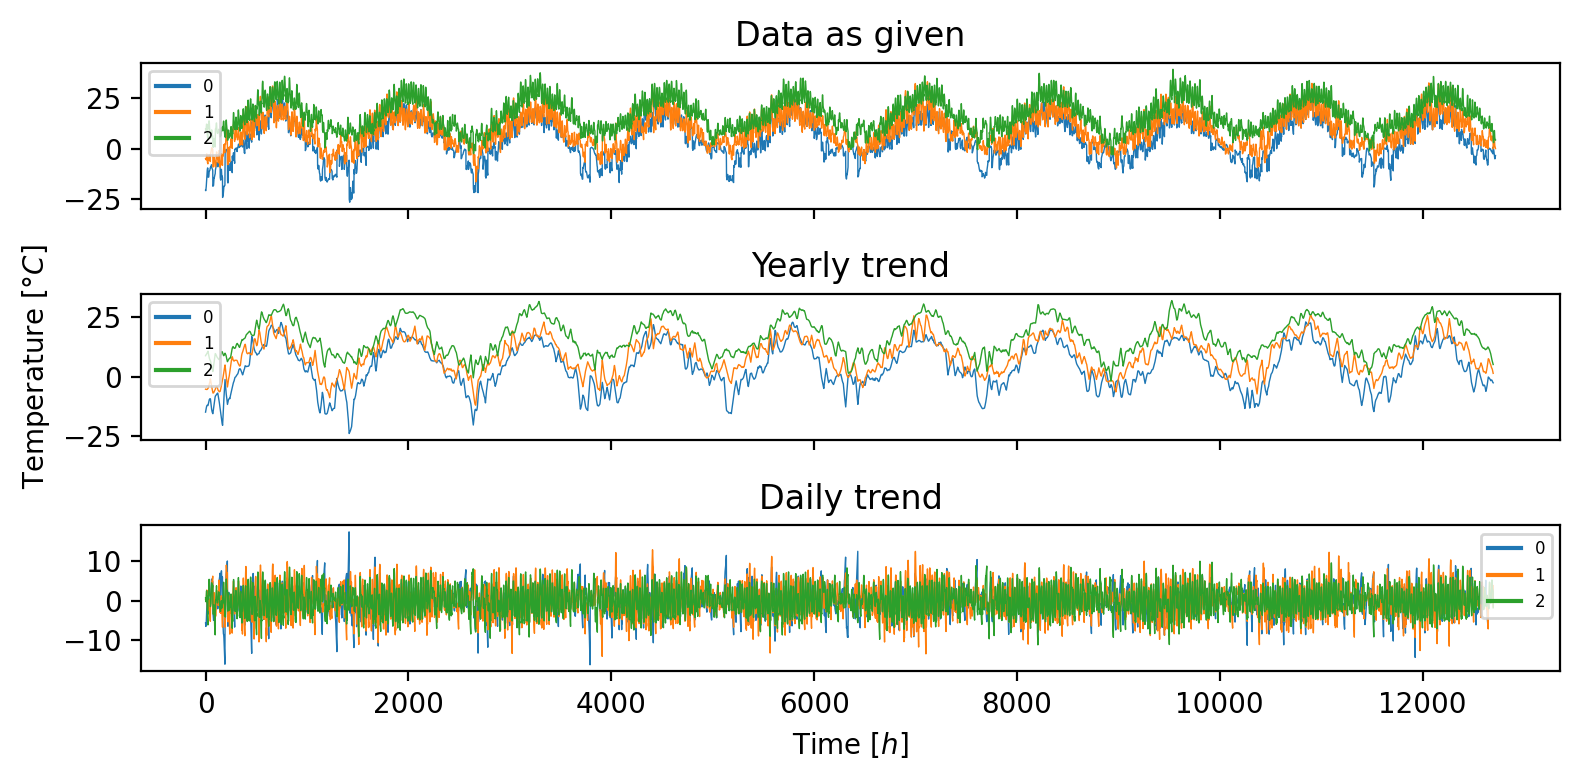

In [360]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex="all", figsize=plt.figaspect(1 / 2))
sns.lineplot(data=npa, ax=axes[0], dashes=False, lw=0.5)
axes[0].set_title("Data as given")

sns.lineplot(data=mnpa, ax=axes[1], dashes=False, lw=0.5)
axes[1].set_title("Yearly trend")
axes[1].set_ylabel("Temperature $[°C]$")

sns.lineplot(data=npa[:-N + 1] - mnpa, ax=axes[2], dashes=False, lw=0.5)
axes[2].set_title("Daily trend")
axes[2].set_xlabel("Time $[h]$")

plt.tight_layout()

## Project Tasks

### 1. Split the time series into a train set containing approximately the first 8 years, and a test set containing the last 2 years.

In [361]:
pivot = int(0.8 * len(npa))

train_data, test_data = npa[:pivot], npa[pivot:]

train_data.shape, test_data.shape

((10176, 3), (2544, 3))

### 2. Implement a linear latent space model

consisting of a latent VAR(1):
$$
z_{t + 1} = A z_t + \epsilon_t , \quad \epsilon_t \sim \mathcal{N}(0, \Sigma) , \quad z_0 \sim \mathcal{N}(\mu_0, \Sigma)
$$

coupled with a linear observation equation:
$$
x_t = B z_t + \eta_t , \quad \eta_t \sim \mathcal{N}(0, \Gamma)
$$

In [362]:
def model(z, A, B, mu, Sigma, Gamma):
    if z is None:
        z = np.random.multivariate_normal(mu, Sigma)

    epsilon = np.random.multivariate_normal(0, Sigma)
    eta = np.random.multivariate_normal(0, Gamma)

    x = B @ z + eta
    z = A @ z + epsilon
    return z, x


def expectation_maximization(observation_model, latent_model, x, z0, max_iter=100, observation_params: dict = None, latent_params: dict = None):
    observation_params = observation_params or {}
    latent_params = latent_params or {}

    for i in range(max_iter):
        z = latent_model.forecast(z0, len(x))
        xhat = observation_model(z, **observation_params)

        observation_model.fit()

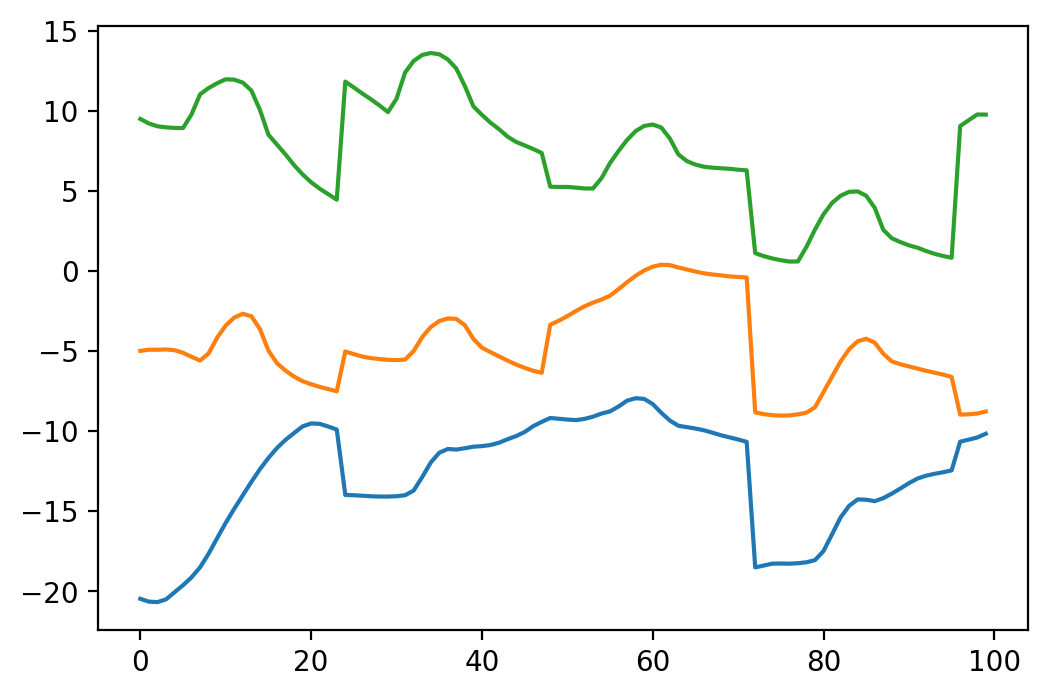

In [363]:
x = npa[0:100]

plt.plot(x)

In [364]:
def wrap_model(model):
    def run_model(x0, *args, iterations, **kwargs):
        output = [x0]
        for _ in range(iterations):
            output.append(
                model(output[-1], *args, **kwargs)
            )

        return np.array(output)

    return run_model

def random_orthogonal(*size):
    qr = np.random.standard_normal(size=size)
    return np.linalg.qr(qr)[0]

In [365]:
@wrap_model
def latent_model(z, A, Sigma):
    mu = np.zeros_like(z)
    epsilon = np.random.multivariate_normal(mu, Sigma)
    return A @ z + epsilon

def observation_model(z, B, Gamma):
    mu = np.zeros(z.shape[1:])
    eta = np.random.multivariate_normal(mu, Gamma, size=z.shape[0])
    output = B @ np.expand_dims(z, -1)
    output = np.squeeze(output) + eta
    return output

In [366]:
mu0 = np.mean(x, axis=0)
Sigma = random_orthogonal(3, 3)
z0 = np.random.multivariate_normal(mu0, Sigma)


# initialize Gamma, A and B as random orthogonal matrices
Gamma = np.cov(x, rowvar=False)
A = random_orthogonal(3, 3)
B = random_orthogonal(3, 3)

/tmp/ipykernel_5719/3389510185.py:3: RuntimeWarning: covariance is not positive-semidefinite.
  z0 = np.random.multivariate_normal(mu0, Sigma)


In [367]:
z = latent_model(z0, A, Sigma, iterations=99)
xhat = observation_model(z, B, Gamma)

/tmp/ipykernel_5719/644336493.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  epsilon = np.random.multivariate_normal(mu, Sigma)


In [368]:
logdet = np.log(np.linalg.det(2 * np.pi * Sigma))
residuals = np.abs(xhat - x)
prod = residuals[:, None, :] @ np.linalg.inv(Sigma) @ residuals[:, :, None]

log_likelihood = -0.5 * np.sum(logdet + prod)

log_likelihood

-29831.46872591268

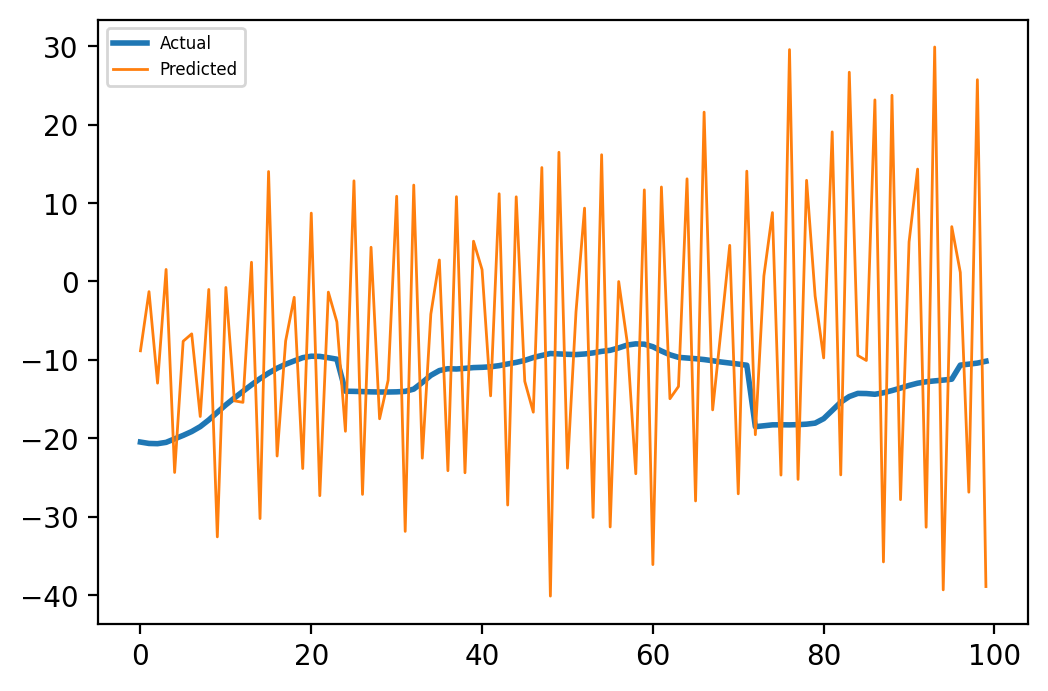

In [373]:
plt.plot(x[:, 0], lw=2, label="Actual")
plt.plot(xhat[:, 0], lw=1, label="Predicted")
plt.legend()

In [369]:
(sign, logabsdet) = np.linalg.slogdet(Sigma)
M = Sigma.shape[0]


log_likelihood_expectation = -0.5 * M * np.log(2 * np.pi) - 0.5 * sign * logabsdet - 0.5 * (z[0] - mu0)[:, None, :] @ np.linalg.inv(Sigma) @ (z[0] - mu0)[:, :, None]